<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

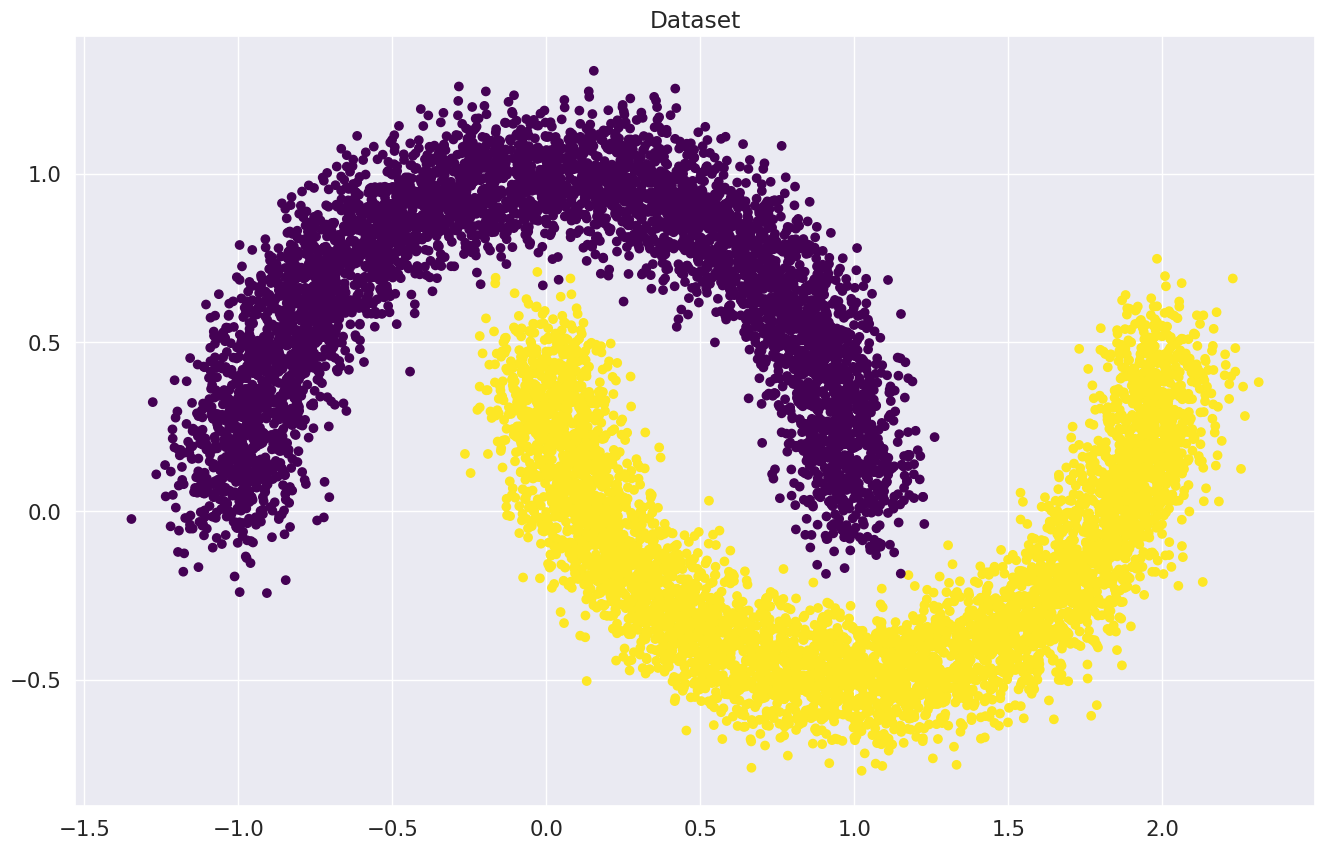

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        x = (x*self.weights).sum(axis=1)
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
param_num = 0
for param in linear_regression.parameters():
    param_num += len(param)
    
print(param_num)

3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.softmax(outp, dim=-1) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.453125
Iteration: 200
Batch accuracy: 0.5390625
Iteration: 300
Batch accuracy: 0.421875
Iteration: 400
Batch accuracy: 0.5234375
Iteration: 500
Batch accuracy: 0.5078125
Iteration: 600
Batch accuracy: 0.59375
Iteration: 700
Batch accuracy: 0.484375
Iteration: 800
Batch accuracy: 0.46875

Iteration: 877.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 696

### Визуализируем результаты

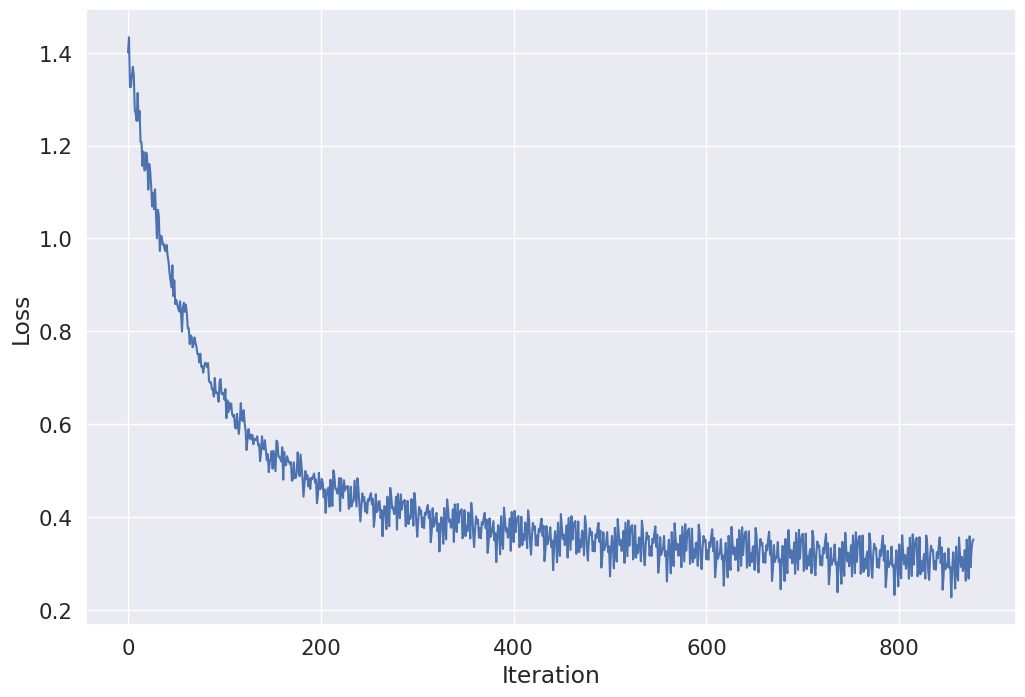

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

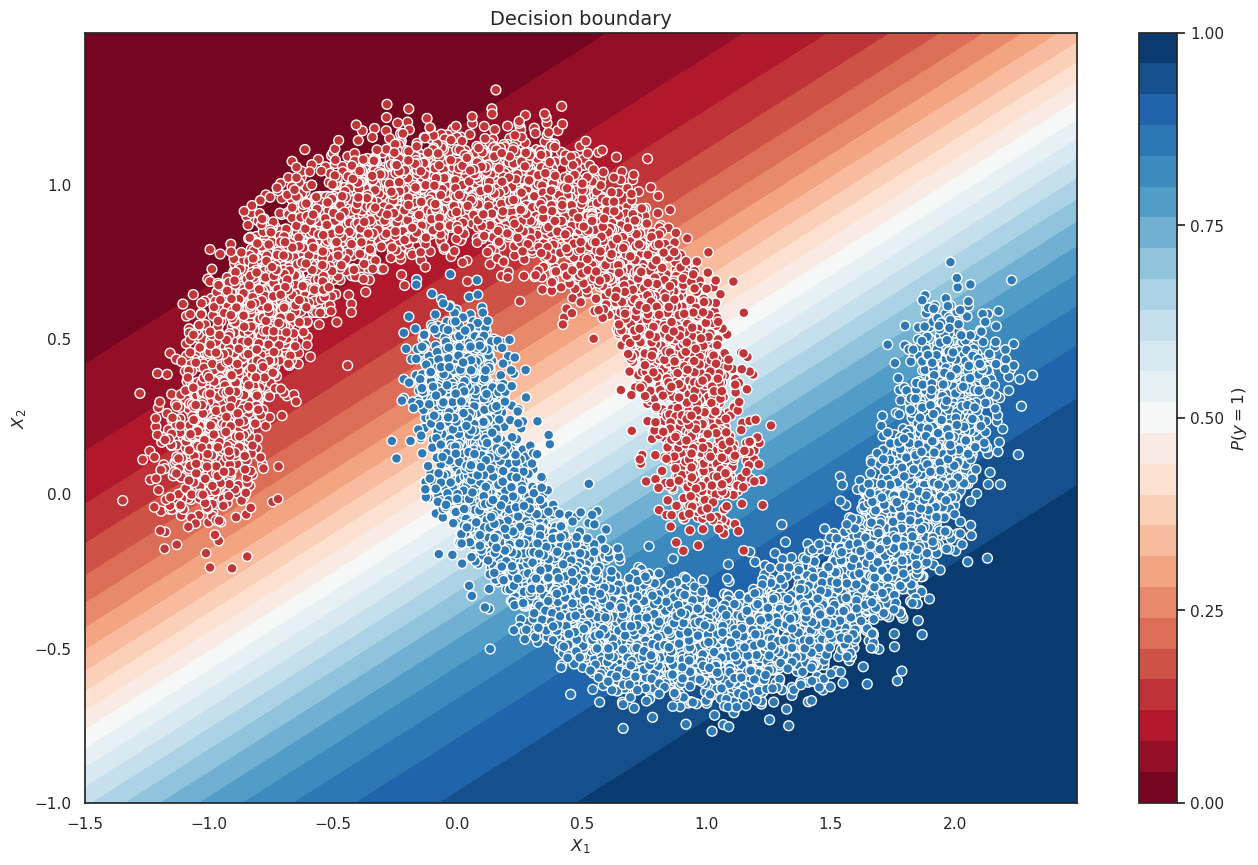

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        probabilities = torch.sigmoid(model(x_batch))
        preds = (probabilities > 0.5).type(torch.long)
        #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
y_pred = predict(val_dataloader, linear_regression)
acc_score = accuracy_score(y_val_t, y_pred)
print(acc_score)

0.8592


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8644

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
import torchvision
from torchvision import transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 28, 28])

In [18]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [19]:
in_features = image.numel()
in_features

784

In [20]:
def create_model(activation, device):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    model.to(device)
    
    return model

In [21]:
activation = nn.ELU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = create_model(activation, device)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [23]:
def train_model(model, loaders, optimizer, criterion, max_epochs, device):
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))

                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).cpu().numpy().mean()
                epoch_correct += correct.item()
                epoch_all += 1
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy

In [24]:
max_epochs = 10

accuracy = train_model(model, loaders, optimizer, criterion, max_epochs, device)

Epoch: 1
Loader: train. Accuracy: 0.9066666666666666
Loader: valid. Accuracy: 0.9263
Epoch: 2
Loader: train. Accuracy: 0.9464833333333333
Loader: valid. Accuracy: 0.9575
Epoch: 3
Loader: train. Accuracy: 0.9553333333333334
Loader: valid. Accuracy: 0.9515
Epoch: 4
Loader: train. Accuracy: 0.96015
Loader: valid. Accuracy: 0.9569
Epoch: 5
Loader: train. Accuracy: 0.9637166666666667
Loader: valid. Accuracy: 0.9531
Epoch: 6
Loader: train. Accuracy: 0.9655166666666667
Loader: valid. Accuracy: 0.9645
Epoch: 7
Loader: train. Accuracy: 0.9680833333333333
Loader: valid. Accuracy: 0.9621
Epoch: 8
Loader: train. Accuracy: 0.9682
Loader: valid. Accuracy: 0.9673
Epoch: 9
Loader: train. Accuracy: 0.9710333333333333
Loader: valid. Accuracy: 0.9518
Epoch: 10
Loader: train. Accuracy: 0.97185
Loader: valid. Accuracy: 0.9634


In [25]:
accuracy['valid']

[0.9263,
 0.9575,
 0.9515,
 0.9569,
 0.9531,
 0.9645,
 0.9621,
 0.9673,
 0.9518,
 0.9634]

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [26]:
def test_activation_function(activation, loaders, criterion, device):

    model = create_model(activation, device)

    optimizer = torch.optim.Adam(model.parameters())

    max_epochs = 10
    accuracy = train_model(model,
                           loaders,
                           optimizer,
                           criterion,
                           max_epochs,
                           device)

    return accuracy['valid']

In [27]:
plain_accuracy = test_activation_function(Identical, loaders, criterion, device)

Epoch: 1
Loader: train. Accuracy: 0.8490833333333333
Loader: valid. Accuracy: 0.8781
Epoch: 2
Loader: train. Accuracy: 0.8821166666666667
Loader: valid. Accuracy: 0.9021
Epoch: 3
Loader: train. Accuracy: 0.8885333333333333
Loader: valid. Accuracy: 0.8881
Epoch: 4
Loader: train. Accuracy: 0.8936666666666667
Loader: valid. Accuracy: 0.8893
Epoch: 5
Loader: train. Accuracy: 0.89545
Loader: valid. Accuracy: 0.8911
Epoch: 6
Loader: train. Accuracy: 0.8972333333333333
Loader: valid. Accuracy: 0.9084
Epoch: 7
Loader: train. Accuracy: 0.8979666666666667
Loader: valid. Accuracy: 0.9111
Epoch: 8
Loader: train. Accuracy: 0.9016666666666666
Loader: valid. Accuracy: 0.9003
Epoch: 9
Loader: train. Accuracy: 0.9018
Loader: valid. Accuracy: 0.9068
Epoch: 10
Loader: train. Accuracy: 0.9029
Loader: valid. Accuracy: 0.905


In [28]:
elu_accuracy = test_activation_function(nn.ELU, loaders, criterion, device)

Epoch: 1
Loader: train. Accuracy: 0.9077833333333334
Loader: valid. Accuracy: 0.9461
Epoch: 2
Loader: train. Accuracy: 0.9481666666666667
Loader: valid. Accuracy: 0.9634
Epoch: 3
Loader: train. Accuracy: 0.9553833333333334
Loader: valid. Accuracy: 0.9559
Epoch: 4
Loader: train. Accuracy: 0.9598666666666666
Loader: valid. Accuracy: 0.9597
Epoch: 5
Loader: train. Accuracy: 0.9633333333333334
Loader: valid. Accuracy: 0.9425
Epoch: 6
Loader: train. Accuracy: 0.9649833333333333
Loader: valid. Accuracy: 0.9655
Epoch: 7
Loader: train. Accuracy: 0.9679833333333333
Loader: valid. Accuracy: 0.9606
Epoch: 8
Loader: train. Accuracy: 0.9690333333333333
Loader: valid. Accuracy: 0.9695
Epoch: 9
Loader: train. Accuracy: 0.9696333333333333
Loader: valid. Accuracy: 0.9673
Epoch: 10
Loader: train. Accuracy: 0.97115
Loader: valid. Accuracy: 0.9601


In [29]:
relu_accuracy = test_activation_function(nn.ReLU, loaders, criterion, device)

Epoch: 1
Loader: train. Accuracy: 0.9016833333333333
Loader: valid. Accuracy: 0.9388
Epoch: 2
Loader: train. Accuracy: 0.94455
Loader: valid. Accuracy: 0.9474
Epoch: 3
Loader: train. Accuracy: 0.9531166666666666
Loader: valid. Accuracy: 0.958
Epoch: 4
Loader: train. Accuracy: 0.9569
Loader: valid. Accuracy: 0.9525
Epoch: 5
Loader: train. Accuracy: 0.9592
Loader: valid. Accuracy: 0.9565
Epoch: 6
Loader: train. Accuracy: 0.9615166666666667
Loader: valid. Accuracy: 0.9553
Epoch: 7
Loader: train. Accuracy: 0.9634333333333334
Loader: valid. Accuracy: 0.9612
Epoch: 8
Loader: train. Accuracy: 0.9641666666666666
Loader: valid. Accuracy: 0.9435
Epoch: 9
Loader: train. Accuracy: 0.9649
Loader: valid. Accuracy: 0.9567
Epoch: 10
Loader: train. Accuracy: 0.9649833333333333
Loader: valid. Accuracy: 0.9666


In [30]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU, loaders, criterion, device)

Epoch: 1
Loader: train. Accuracy: 0.9045
Loader: valid. Accuracy: 0.9453
Epoch: 2
Loader: train. Accuracy: 0.9454666666666667
Loader: valid. Accuracy: 0.9538
Epoch: 3
Loader: train. Accuracy: 0.9540833333333333
Loader: valid. Accuracy: 0.9596
Epoch: 4
Loader: train. Accuracy: 0.9586
Loader: valid. Accuracy: 0.9614
Epoch: 5
Loader: train. Accuracy: 0.9614666666666667
Loader: valid. Accuracy: 0.9645
Epoch: 6
Loader: train. Accuracy: 0.9633
Loader: valid. Accuracy: 0.9513
Epoch: 7
Loader: train. Accuracy: 0.9640833333333333
Loader: valid. Accuracy: 0.9594
Epoch: 8
Loader: train. Accuracy: 0.9657166666666667
Loader: valid. Accuracy: 0.9642
Epoch: 9
Loader: train. Accuracy: 0.96675
Loader: valid. Accuracy: 0.964
Epoch: 10
Loader: train. Accuracy: 0.9677333333333333
Loader: valid. Accuracy: 0.9589


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

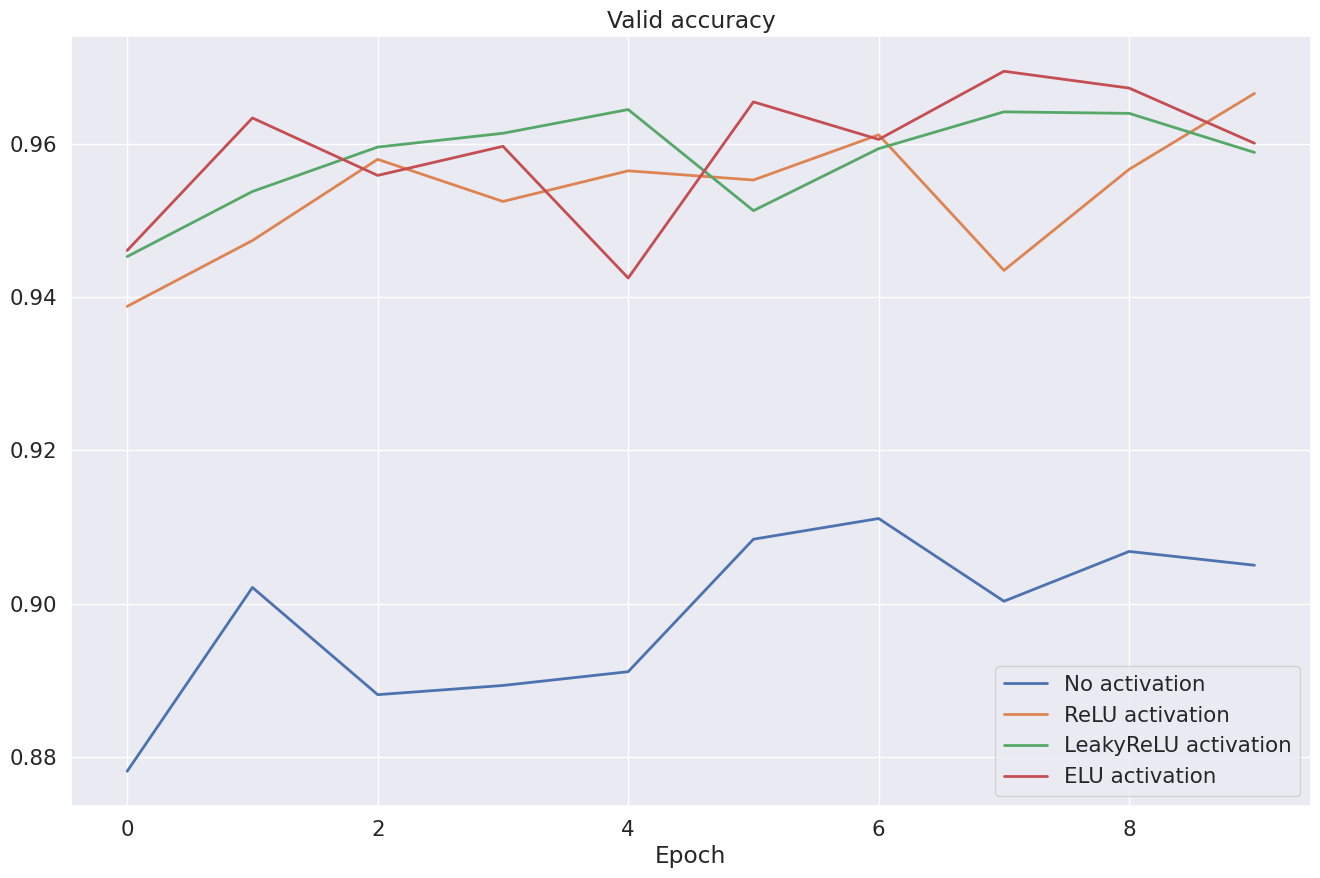

In [31]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

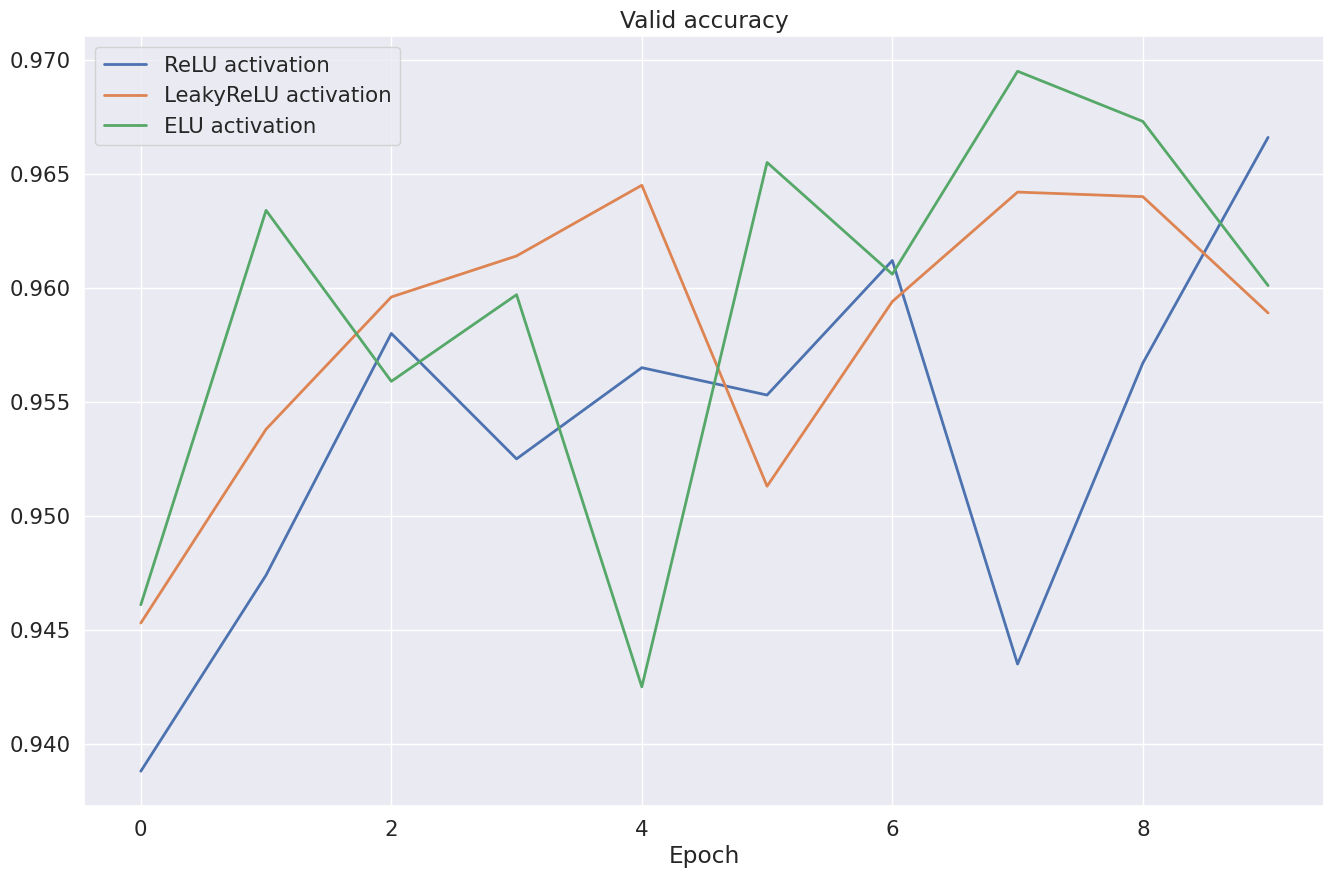

In [32]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [34]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-06-05 10:13:33--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-06-05 10:13:34--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 188.114.96.1, 188.114.97.1, 2a06:98c1:3121::1, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|188.114.96.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.1s    

2023-06-05 10:13:35 (432 KB/s)

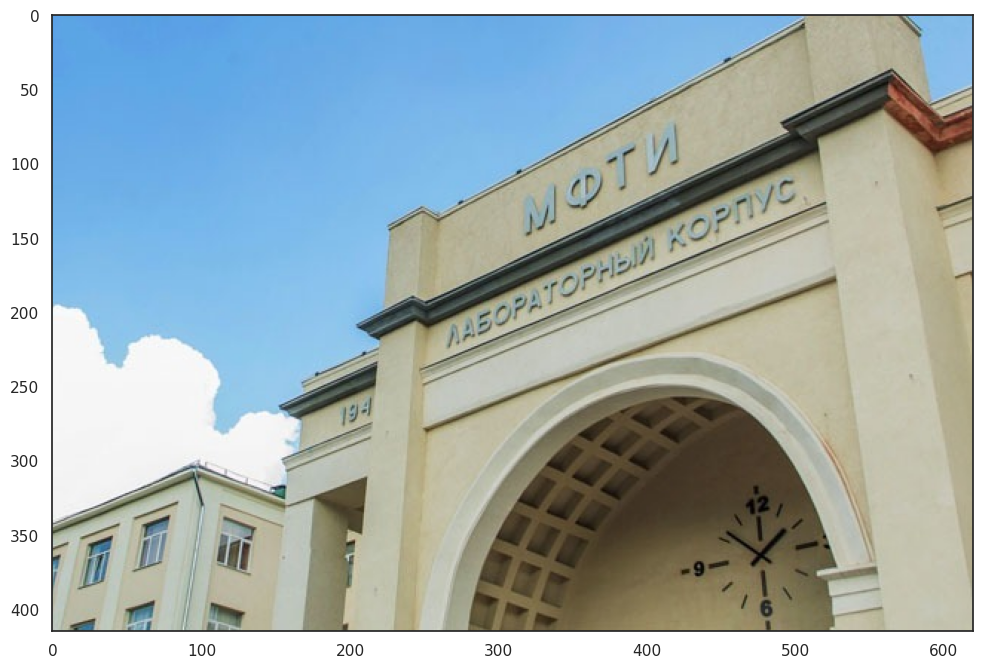

In [39]:
import cv2

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [40]:
#A
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

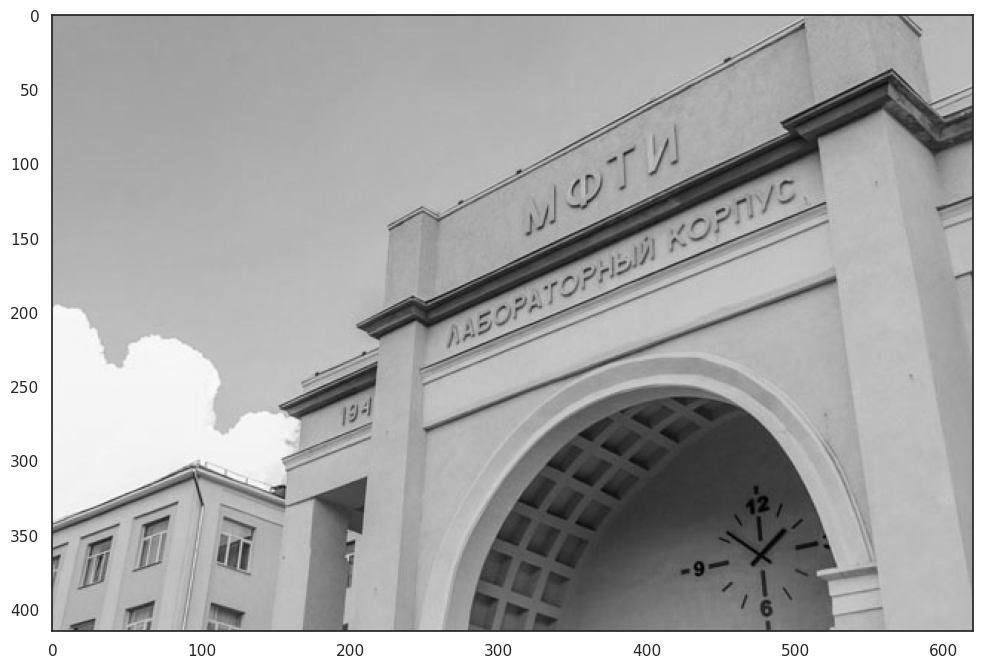

In [41]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


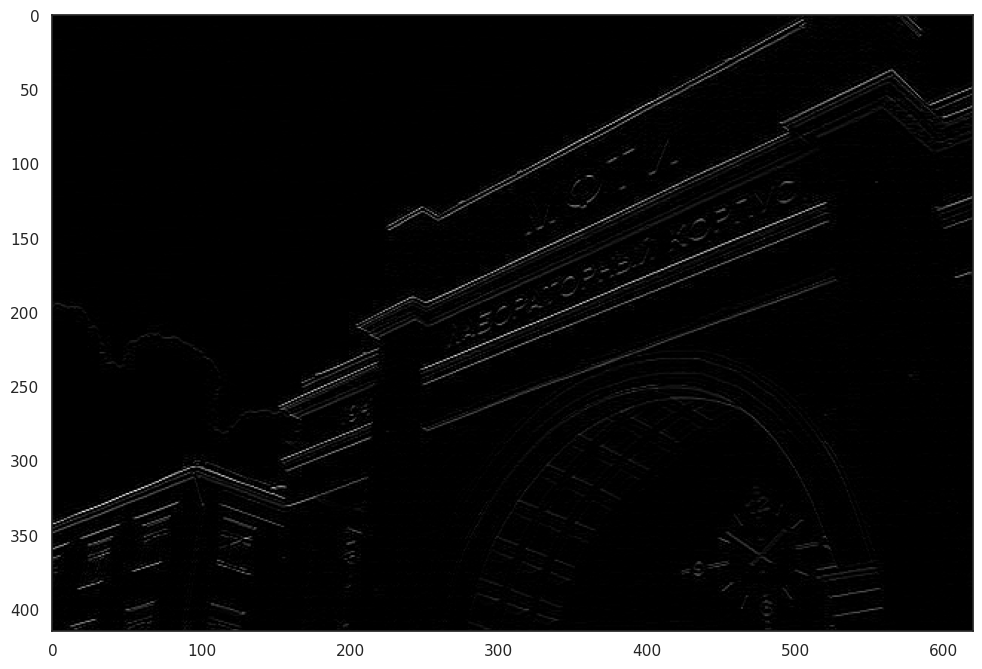

In [42]:
#Б
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


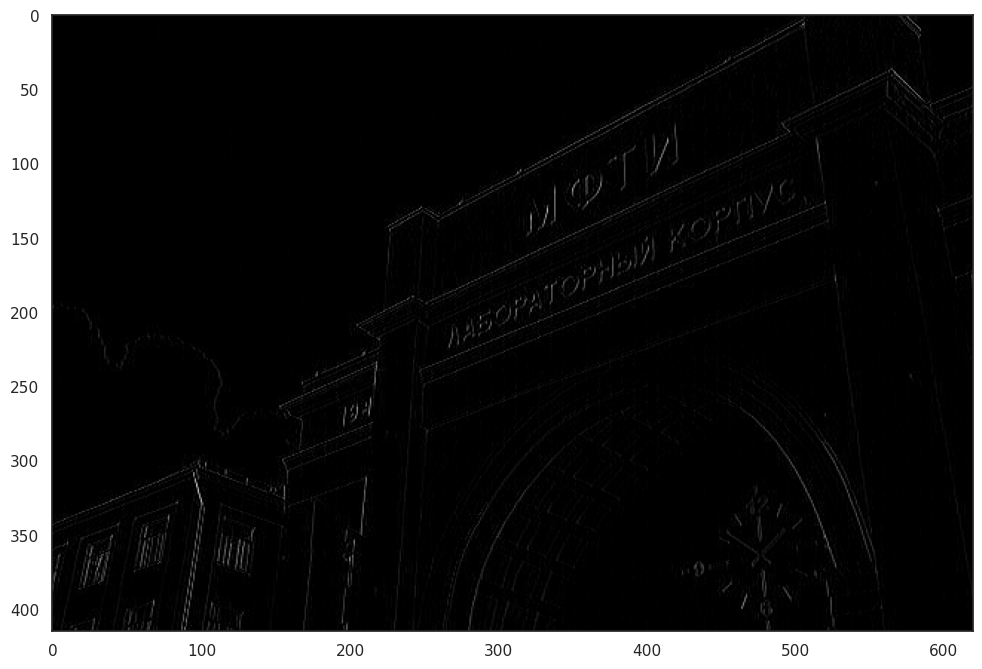

In [43]:
#В
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


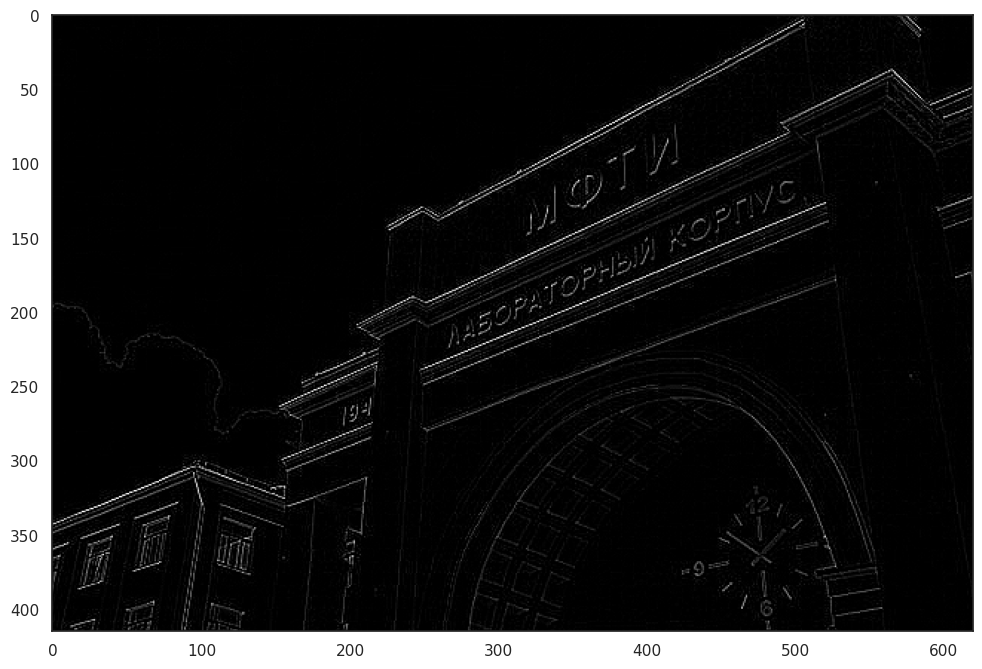

In [44]:
#Г
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


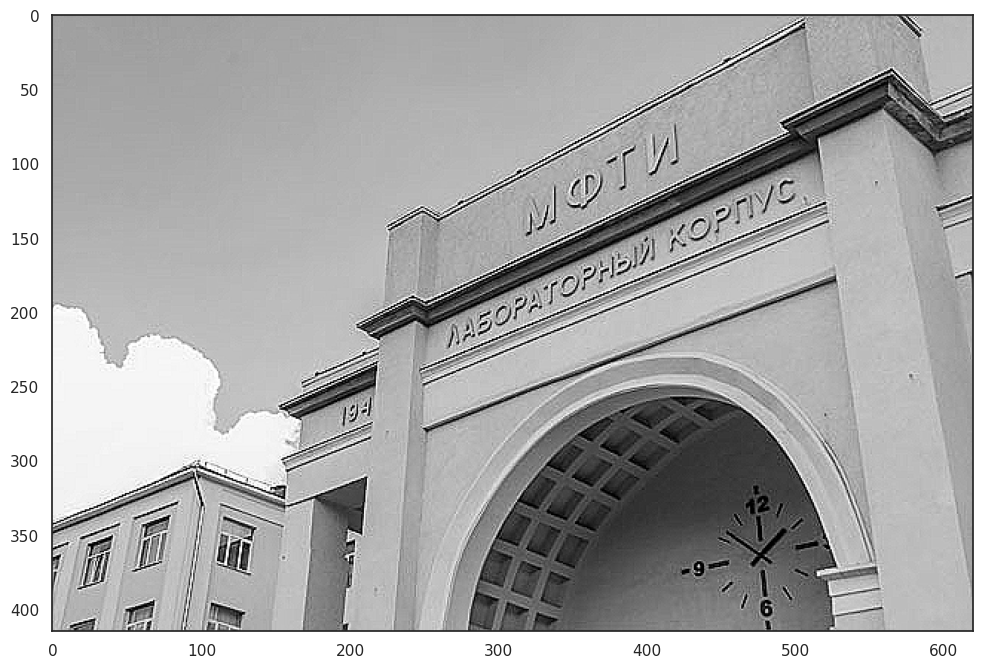

In [45]:
#Д
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

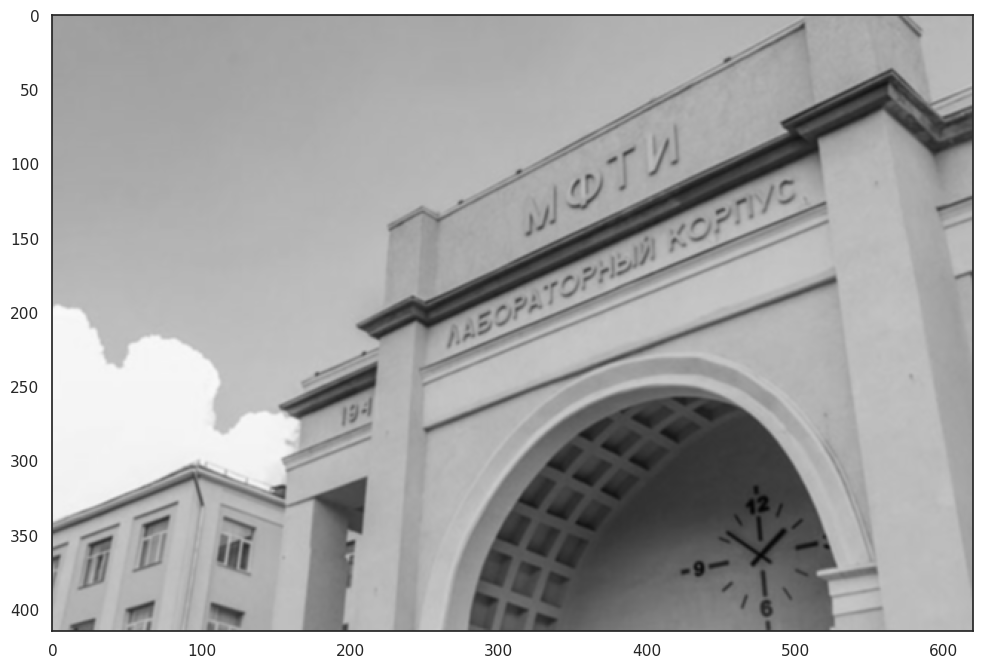

In [46]:
#Е
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1-Е, 2-Д, 3-A, 4-В, 5-Б, 6-Г.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [47]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x): 
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}
max_epochs = 10

In [49]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
# удобно ли использовать функцию ? )
# рассказать про практику выноса функций в отдельные python-модули
accuracy = train_model(model, loaders, optimizer, criterion, max_epochs, device)

Epoch: 1
Loader: train. Accuracy: 0.9520666666666666
Loader: valid. Accuracy: 0.9828
Epoch: 2
Loader: train. Accuracy: 0.9808166666666667
Loader: valid. Accuracy: 0.9814
Epoch: 3
Loader: train. Accuracy: 0.9859666666666667
Loader: valid. Accuracy: 0.9884
Epoch: 4
Loader: train. Accuracy: 0.9875666666666667
Loader: valid. Accuracy: 0.9893
Epoch: 5
Loader: train. Accuracy: 0.9893166666666666
Loader: valid. Accuracy: 0.9869
Epoch: 6
Loader: train. Accuracy: 0.9898
Loader: valid. Accuracy: 0.9876
Epoch: 7
Loader: train. Accuracy: 0.9914666666666667
Loader: valid. Accuracy: 0.9866
Epoch: 8
Loader: train. Accuracy: 0.9922166666666666
Loader: valid. Accuracy: 0.988
Epoch: 9
Loader: train. Accuracy: 0.9927
Loader: valid. Accuracy: 0.9851
Epoch: 10
Loader: train. Accuracy: 0.9928166666666667
Loader: valid. Accuracy: 0.9861


In [51]:
lenet_accuracy = accuracy["valid"]

In [52]:
lenet_accuracy

[0.9828, 0.9814, 0.9884, 0.9893, 0.9869, 0.9876, 0.9866, 0.988, 0.9851, 0.9861]

Сравним с предыдущем пунктом

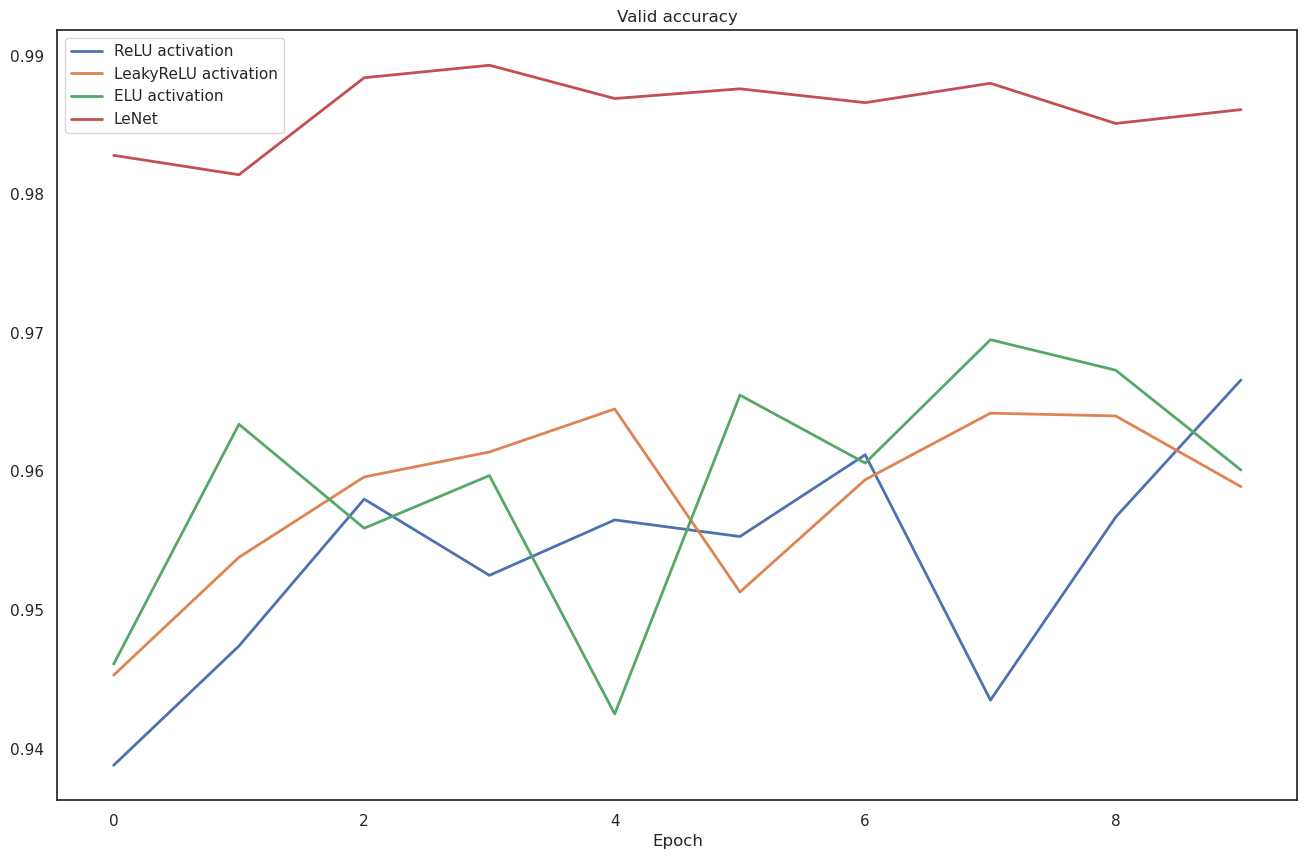

In [53]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98